In [15]:
# Importing packages
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
# recall_score, roc_auc_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, fbeta_score
import joblib
import pickle

df = pd.read_csv('data/Cardiovascular_Diseases_Risk_Prediction_Dataset.csv')[['Heart_Disease', 'Arthritis','Diabetes','Age_Category','General_Health','Sex','Smoking_History']]

categorical = ['Diabetes','Arthritis', 'Smoking_History', 'Sex']
ordinal = ['General_Health', 'Age_Category']

In [16]:
df

,Heart_Disease,Arthritis,Diabetes,Age_Category,General_Health,Sex,Smoking_History
0,No,Yes,No,70-74,Poor,Female,Yes
1,Yes,No,Yes,70-74,Very Good,Female,No
2,No,No,Yes,60-64,Very Good,Female,No
3,Yes,No,Yes,75-79,Poor,Male,No
4,No,No,No,80+,Good,Male,Yes
...,...,...,...,...,...,...,...
308849,No,No,No,25-29,Very Good,Male,No
308850,No,No,Yes,65-69,Fair,Male,No
308851,No,No,"Yes, but female told only during pregnancy",30-34,Very Good,Female,Yes
308852,No,No,No,65-69,Very Good,Male,No


## Data Preparation
***
The first step in our data preparation is to split the data in to test and train sets. We need to be careful to only use the test data as the last step in the evaluation process to avoid data leakage. 

In [17]:
y = df['Heart_Disease']
X = df.drop('Heart_Disease', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12,stratify=y)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
age = [
    '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
    '60-64', '65-69', '70-74', '75-79', '80+'
]
oe = OrdinalEncoder(categories=[health, age])
ohe = OneHotEncoder()
ct = ColumnTransformer(
    transformers=[('oe', OrdinalEncoder(categories=[health, age]), ordinal),
                  ('ohe', OneHotEncoder(), categorical)
                 ],
                       remainder="passthrough")
# X_train = ct.fit_transform(X_train)
# X_test = ct.transform(X_test)

In [18]:
X_train

,Arthritis,Diabetes,Age_Category,General_Health,Sex,Smoking_History
154606,No,No,70-74,Very Good,Female,No
223948,Yes,No,40-44,Fair,Female,Yes
298682,Yes,No,75-79,Very Good,Male,Yes
185124,Yes,No,80+,Good,Female,No
23179,No,No,25-29,Very Good,Male,Yes
...,...,...,...,...,...,...
211103,No,No,30-34,Good,Female,No
260084,No,No,80+,Very Good,Female,No
255412,No,No,25-29,Very Good,Female,No
88393,No,No,40-44,Good,Male,Yes


## Data Modeling
***
Since our stakeholder wants to identify as many people as possible who could have a heart condition and the cost of a false positive (identifying a person as likely to have a heart condition when they will not) is low, then we should prioritize the true positive rate, or recall. Given the imbalance in our dataset, I will use the f2-score as my evaluation metric. This is a weighted harmonic mean between precision and recall which gives more weight to recall.

Additionally, I will use pipelines when cross-validating and scoring my data as to avoid data leakage. 

In [25]:
with open('pickles/gs_params.pkl', 'rb') as h:
    gs_params = pickle.load(h)
gs_params

{'xbg__eta': 0.1, 'xbg__max_depth': 2, 'xbg__n_estimators': 400}

In [26]:
X_train

,Arthritis,Diabetes,Age_Category,General_Health,Sex,Smoking_History
154606,No,No,70-74,Very Good,Female,No
223948,Yes,No,40-44,Fair,Female,Yes
298682,Yes,No,75-79,Very Good,Male,Yes
185124,Yes,No,80+,Good,Female,No
23179,No,No,25-29,Very Good,Male,Yes
...,...,...,...,...,...,...
211103,No,No,30-34,Good,Female,No
260084,No,No,80+,Very Good,Female,No
255412,No,No,25-29,Very Good,Female,No
88393,No,No,40-44,Good,Male,Yes


In [29]:
num_negatives = (y_train==0).sum()
num_positives = (y_train==1).sum()
neg_pos_ratio = num_negatives / num_positives
xgb = XGBClassifier(reg_lambda=10,
                    reg_alpha=0.1,
                    min_child_weight=1,
                    gamma=10,
                    colsample_bytree=3 / 7,
                    tree_method="hist",
                    scale_pos_weight=neg_pos_ratio,
                    random_state=12,
                   eta=0.1,
                   max_depth=2,
                   n_estimators= 400)


pipe = Pipeline(steps=[('ct', ct), ('xbg', xgb)])

modelo = pipe.fit(X_train,y_train)

In [32]:
# Importing packages
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay 
# recall_score, roc_auc_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, fbeta_score
import joblib
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score
def model_scores(model, X, y, model_list=[], cv=5, model_name=''):
    """
    This is a helper function which takes in a fitted estimator, and cross validates it, calculating the f2-score, accuracy, recall, and roc_auc score. It outputs the summary as a dataframe. It also outputs a list in the case that the table builds on itself. 
    """
    if cv > 1:
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=12)
        scoring = {
            'f2': make_scorer(fbeta_score, beta=2),
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, zero_division=0.0),
            'recall': 'recall',
            'roc_auc': 'roc_auc'
        }
        scores = cross_validate(model,
                                X,
                                y,
                                scoring=scoring,
                                cv=skf,
                                n_jobs=-1)
        f2 = round(scores['test_f2'].mean(), 4) * 100
        accuracy = round(scores['test_accuracy'].mean(), 4) * 100
        precision = round(scores['test_precision'].mean(), 4) * 100
        recall = round(scores['test_recall'].mean(), 4) * 100
        roc_auc = round(scores['test_roc_auc'].mean(), 4) * 100
    else:
        y_preds = model.predict(X)
        f2 = round(fbeta_score(y, y_preds, beta=2), 4) * 100
        recall = round(recall_score(y, y_preds), 4) * 100
        accuracy = round(accuracy_score(y, y_preds), 4) * 100
        precision = round(precision_score(y, y_preds, zero_division=0.0),
                          4) * 100
        roc_auc = round(roc_auc_score(y, y_preds), 4) * 100
    model_list.append([model_name, f2, accuracy, precision, recall, roc_auc])
    df = pd.DataFrame(
        model_list,
        columns=['name', 'f2', 'accuracy', 'precision', 'recall', 'roc_auc'])
    return model_list, df

ml, df9 = model_scores(modelo, X_train, y_train, model_name='less feats')
df9

,name,f2,accuracy,precision,recall,roc_auc
0,less feats,49.85,72.01,19.77,80.47,83.27


In [33]:
ml, df9 = model_scores(modelo, X_test, y_test, model_name='less feats')
df9

,name,f2,accuracy,precision,recall,roc_auc
0,less feats,49.85,72.01,19.77,80.47,83.27
1,less feats,50.04,72.70,20.08,79.80,83.51


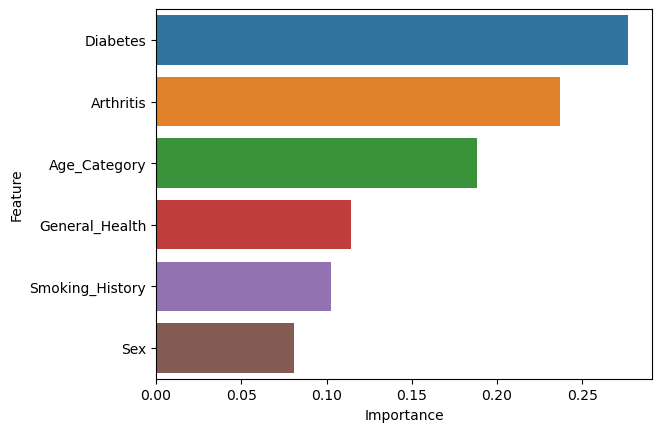

In [34]:
fi = modelo.named_steps['xbg'].feature_importances_
fn = modelo[:-1].get_feature_names_out()

df3 = pd.DataFrame({'Feature':fn, 'Importance': fi}).sort_values('Importance', ascending = False)
df3

def clean_features(feature):
    feats = ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    for i in feats:
        if i in feature:
            return i
        else:
            pass
df3['Feature'] = df3['Feature'].apply(clean_features) 

# Combining the features and adding their importance
df4 = df3.groupby('Feature').sum().sort_values('Importance', ascending= False)
df4

fig, ax = plt.subplots()
ax = sns.barplot(x=df4['Importance'], y=df4.index)

Grid searching helped improve metrics across the board. I will use this as the final model. 

## Evaluation
***
Now that we have found the final model, I will score each of our models on the test data. 

### Feature Importance

Looking at feature importances could help the hospital determine which questions on the questionare to include, and which to omit. It is important to remember that these figures represent the importance of these features **to the specific** model and not necessarily

In [104]:
# Making a dataframe with the feature name and its importance.
fi = gs_model.named_steps['xbg'].feature_importances_
fn = gs_model[:-1].get_feature_names_out()

df3 = pd.DataFrame({'Feature':fn, 'Importance': fi}).sort_values('Importance', ascending = False)
df3



,Feature,Importance
2,oe__Age_Category,0.194362
16,ohe__Arthritis_Yes,0.159462
0,oe__General_Health,0.153559
13,ohe__Diabetes_Yes,0.120359
11,ohe__Diabetes_No,0.077498
19,ohe__Smoking_History_No,0.051027
15,ohe__Arthritis_No,0.041956
18,ohe__Sex_Male,0.039063
17,ohe__Sex_Female,0.038595
1,oe__Checkup,0.026356


While we could make some conclusions about feature importance, it would be more helpful to have the original features as they correspond to questions on the questionaire. For example, instead of knowing 'ohe__Arthritis__Yes' has an importance of about 0.159 and 'ohe__Arthritis_No' has about 0.042, it would be easier to interpret and compare if these were combined into one feature, 'Arthritis' with an importance of about 0.159 + 0.042 = 0.201. 

In [105]:
# This will clean the feature names back to the original feature names
def clean_features(feature):
    feats = ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    for i in feats:
        if i in feature:
            return i
        else:
            pass
df3['Feature'] = df3['Feature'].apply(clean_features) 

# Combining the features and adding their importance
df4 = df3.groupby('Feature').sum().sort_values('Importance', ascending= False)
df4

,Importance
Feature,
Arthritis,0.201418
Diabetes,0.199771
Age_Category,0.194362
General_Health,0.153559
Sex,0.077658
Smoking_History,0.075105
Checkup,0.026356
Depression,0.019750
Skin_Cancer,0.012702


Let's see this visually.

''

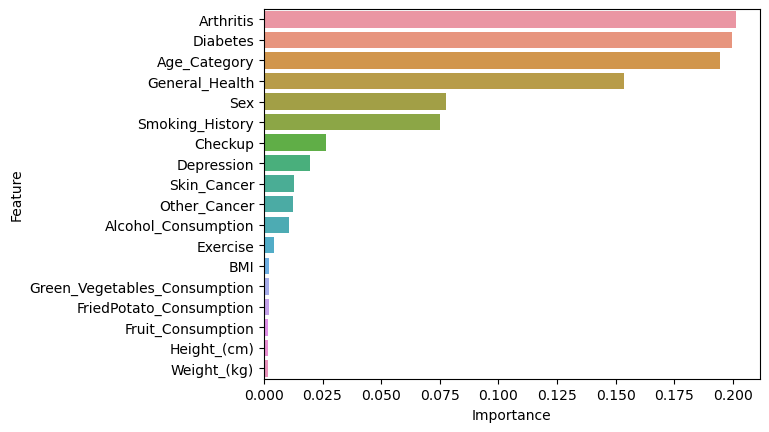

In [114]:
fig, ax = plt.subplots()
ax = sns.barplot(x=df4['Importance'], y=df4.index)

;

`Arthritis`, `Diabetes`, `Age`, `General_Health` are the most important features, with `Sex` and `Smoking_History` in the next tier of importance. 

## Conclusions

### Recommendations
- Based on our final model I would recommend that the hospital develop a questionaire to gather the appropriate information and to use the model to inform medical decisions. 
- Depending on the needs and resources of the hospital, we could adjust the classification threshold to increase our true positive rate or decrease our false positive rate. 

### Limitations
- This model would not be as helpful in cases where the cost of a positve identification is increased, such as recommending a more invasive procedure, medication, or otherwise more expenive or cumbersome consequence.  
- It may be difficult to get 18 pieces of data from a patient. 

### Next Steps
- It could be helpful to look at feature importance. Eliminating features in the model may make it easier for the hospital to collect data without sacrificing the model's performance. 
- It could also be helpful to research if there are other features which may help predict having a heart condition.